# Independent Component Analysis

DataFun

Members:
Jan Botscch, Fabian Frank, David Munkacsi

In [1]:
import numpy as np
import scipy.io.wavfile as wav
from scipy.stats.stats import pearsonr 
import matplotlib.pyplot as plt
import pandas as pd

# 5.1 Initalization

a)

In [2]:
#defines
samplerate = 8192
N = 2
p = 18000

#load the data
dataSet1 = np.loadtxt('./sounds/sound1.dat')
dataSet2 = np.loadtxt('./sounds/sound2.dat')
s = np.stack([dataSet1, dataSet2], axis=0)

print (s.shape)

(2, 18000)


b)

In [3]:
# create random and invertible NxN (2x2) matrix
while True:
    A = np.random.rand(2,2)
    if np.linalg.det(A) != 0.0:
        break
print("A=" + str(A))

#mix the sources
x = np.matmul(A, s)
print('X: ', x[:,:10])
print('x.shape(): ', x.shape)

A=[[ 0.99565872  0.12316593]
 [ 0.56069203  0.37596918]]
X:  [[  0.00000000e+00  -1.95825197e-05  -5.14908556e-04  -1.22762943e-03
    4.54176510e-04  -3.33781882e-04  -1.33148014e-03   2.32399611e-04
   -4.17570992e-03  -1.13317223e-03]
 [  0.00000000e+00  -5.97764634e-05  -1.47821658e-03  -1.43169606e-03
    4.50758794e-04   1.32020196e-03   1.45954267e-04  -1.25542197e-03
   -4.32582323e-03  -5.98526768e-03]]
x.shape():  (2, 18000)


c)

In [4]:
# remove temporal structure by permutation 
x_per = x[:, np.random.permutation(range(0,p))]
print(x_per[:,:10])
print("x_per=" + str(x_per.shape))


[[-0.85544087 -0.10861721 -2.86630132  1.08607794 -0.15205087 -0.6056312
  -0.01170024  0.20692227 -0.00389692  0.02334669]
 [-1.0146798  -0.20122477 -1.60441864  0.11746489 -0.48276079 -0.40107823
  -0.16604929  0.66887716 -0.01189552  0.42968476]]
x_per=(2, 18000)


d)

In [5]:
#calculate correlation between sources and mixtures
s_std = np.std(s,axis=1)
x_per_std = np.std(x_per,axis=1)
print(s_std)
print(x_per_std) 

corr = np.zeros((2, 2))
for i in range(0,2):
	for j in range(0,2):
		#print("i=" + str(i) + " j=" + str(j))
		corr[i,j] = np.cov(s[i,:], x_per[j,:])[0][1] / (s_std[i] * x_per_std[j])
		#print(np.cov(s[i,:], x_per[j,:]))
		#print("corr[i,j]=" + str(corr[i,j]))
print("correlations=" + str(corr))

corr_np = np.corrcoef(s,x_per)
print(corr_np)


[ 0.99854594  0.99885435]
[ 1.00194755  0.67455253]
correlations=[[ 0.01674293  0.02096571]
 [-0.00034748  0.00475967]]
[[  1.00000000e+00   1.26039640e-03   1.67419998e-02   2.09645478e-02]
 [  1.26039640e-03   1.00000000e+00  -3.47462216e-04   4.75940067e-03]
 [  1.67419998e-02  -3.47462216e-04   1.00000000e+00   8.92770668e-01]
 [  2.09645478e-02   4.75940067e-03   8.92770668e-01   1.00000000e+00]]


e)

In [6]:
#center the data
mean = np.mean(x_per,axis=1, keepdims=True)
x_per = x_per - mean;
print("\n mean: " + str(mean))


 mean: [[ 0.00277116]
 [ 0.00543943]]


f)

In [7]:
#initialize W at random
W_init = np.random.rand(2,2)
W_nat_init = np.copy(W_init)
print("W_nat=" + str(W_nat_init))

W_nat=[[ 0.84323268  0.64203372]
 [ 0.91369678  0.34992874]]


# 5.2 Optimization

In [8]:
#function that calculates f''/f' 
def stepSigmoid(y):
	return 1 - 2 * (1 / (1 + np.exp(-y)))

#vectorize function
vStepSigmoid = np.vectorize(stepSigmoid)

def perform_ica(x, W, W_nat, eps=0.01):
#perform ica
#eps = 0.01
    convSpeed = np.empty([0,2])
    for i in range(0,p):
        #normal gradient
        dW = np.linalg.inv(W).T + np.outer(vStepSigmoid(np.dot(W,x[:,i])),x[:,i])
        W = W + eps * dW
        #natural gradient
        dW_nat = np.linalg.inv(W_nat).T + np.outer(vStepSigmoid(np.dot(W_nat,x[:,i])),x[:,i])
        W_nat = W_nat + eps * dW_nat * (np.matmul(W_nat.T, W_nat))
    
        if (i % 1000 == 0):
            convSpeed = np.vstack((convSpeed, [np.sum(W**2), np.sum(W_nat**2)]))
            
    return (W, W_nat, convSpeed)

W, W_nat, convSpeed = perform_ica(x_per, W_init, W_nat_init)
    
print("W final=" + str(W))
print("W_nat final=" + str(W))
print('ConvSpeed: ', convSpeed.shape)

# get the unmixed signals
unmixedNormal = np.matmul(W, x)
unmixedNatural = np.matmul(W_nat, x)

W final=[[-3.0052434   5.79886784]
 [ 3.39316253 -1.66450702]]
W_nat final=[[-3.0052434   5.79886784]
 [ 3.39316253 -1.66450702]]
ConvSpeed:  (18, 2)


# 5.3 Results

(a) Plot and Play

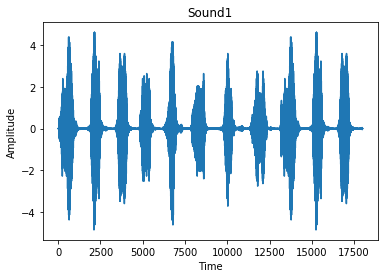

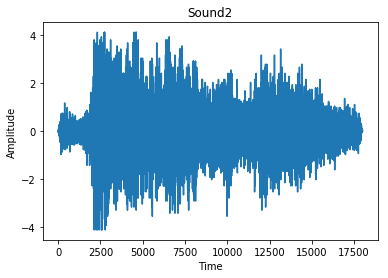

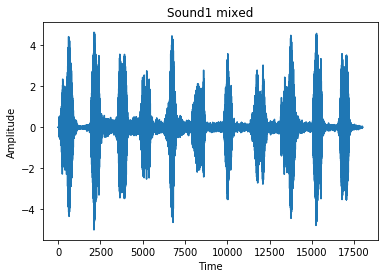

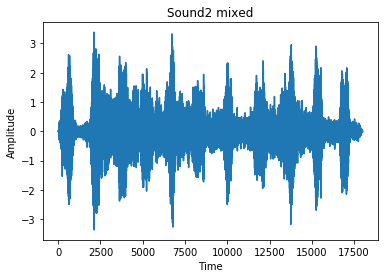

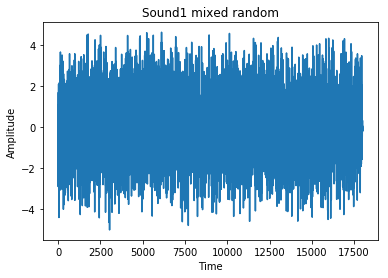

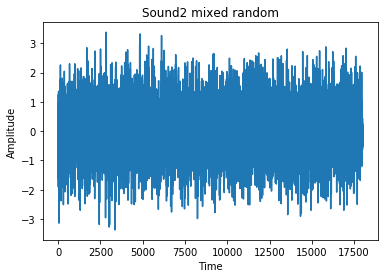

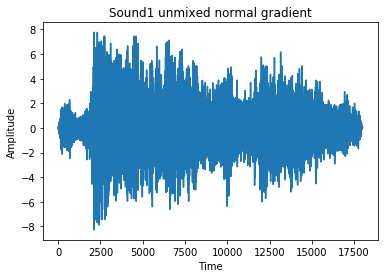

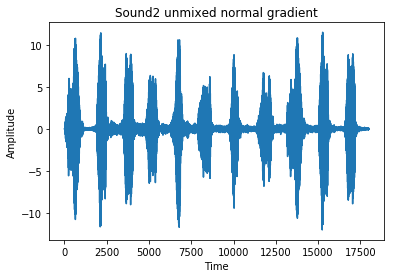

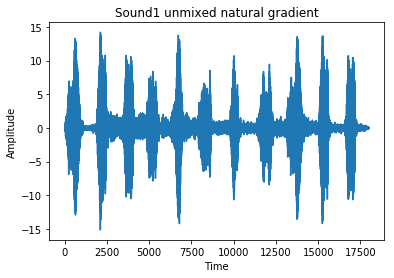

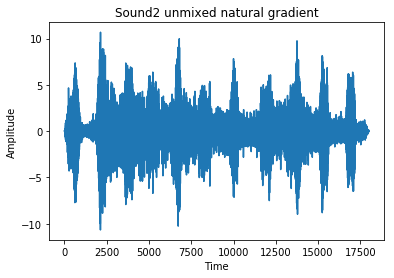

In [9]:
# Original sounds.
wav.write('Source1.wav',8192,dataSet1)
wav.write('Source2.wav',8192,dataSet2)

# Mixed sounds.
wav.write('Mixed1.wav',8192,x[0,:])
wav.write('Mixed2.wav',8192,x[1,:])

# Mixed and permutated.
wav.write('MixedPerm1.wav',8192,x_per[0,:])
wav.write('MixedPerm2.wav',8192,x_per[1,:])

# Unmixed with normal gradient.
wav.write('UnmixedNormGrad1.wav',8192,unmixedNormal[0,:])
wav.write('UnmixedNormGrad2.wav',8192,unmixedNormal[1,:])

# Unmixed with natural gradient.
wav.write('UnmixedNatGrad1.wav',8192,unmixedNatural[0,:])
wav.write('UnmixedNatGrad2.wav',8192,unmixedNatural[1,:])

plt.figure()
plt.plot(dataSet1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1')

plt.figure()
plt.plot(dataSet2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2')

plt.figure()
plt.plot(x[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 mixed')
plt.figure()
plt.plot(x[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 mixed')

plt.figure()
plt.plot(x_per[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 mixed random')
plt.figure()
plt.plot(x_per[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 mixed random')

plt.figure()
plt.plot(unmixedNormal[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 unmixed normal gradient')
plt.figure()
plt.plot(unmixedNormal[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 unmixed normal gradient')

plt.figure()
plt.plot(unmixedNatural[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 unmixed natural gradient')
plt.figure()
plt.plot(unmixedNatural[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 unmixed natural gradient')

plt.show()

(b) Calculate correlations between the true sources and the estimations

In [10]:
corrRecNorm = np.corrcoef(s,unmixedNormal)
corrRecNat = np.corrcoef(s,unmixedNatural)
print('Correlation unmixedNormal: ', corrRecNorm)
print('Correlation unmixedNatural: ', corrRecNat)

Correlation unmixedNormal:  [[ 1.          0.0012604   0.14292424  0.99640251]
 [ 0.0012604   1.          0.98991299 -0.08349101]
 [ 0.14292424  0.98991299  1.          0.05853318]
 [ 0.99640251 -0.08349101  0.05853318  1.        ]]
Correlation unmixedNatural:  [[ 1.          0.0012604   0.98404335 -0.78065521]
 [ 0.0012604   1.          0.17916904 -0.62594539]
 [ 0.98404335  0.17916904  1.         -0.87939736]
 [-0.78065521 -0.62594539 -0.87939736  1.        ]]


(c) Comparing learning speed, data whitening

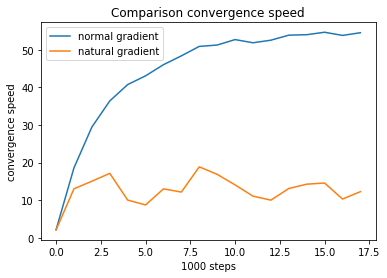

In [11]:
plt.figure()
norm_label, = plt.plot(convSpeed[:,0], label='normal gradient')
nat_label, = plt.plot(convSpeed[:,1], label='natural gradient')
plt.xlabel('1000 steps')
plt.ylabel('convergence speed')
plt.title('Comparison convergence speed')
plt.legend(handles=[norm_label, nat_label])
plt.show()

The convergence speed for normal gradient is higher than for natural gradient, and it seems to reaches a plateau and stay at this level after a reasonable number of steps.
The natural gradient is similar, but has more variance than normal gradient.

Whitening:

[[ 1.00395467  0.60342709]
 [ 0.60342709  0.45504639]]
(2, 18000)


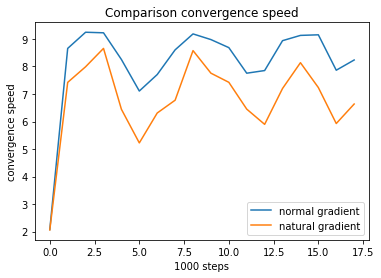

In [12]:
cov = np.cov(x_per)
print(cov)
eigval, eigvec = np.linalg.eig(cov)
Lambda = np.diag(1/np.sqrt(eigval))
x_white = (x_per.T @ eigvec @ Lambda).T
print(x_white.shape)

W_w, W_nat_w, convSpeed_w = perform_ica(x_white, W_init, W_nat_init)

plt.figure()
norm_label_w, = plt.plot(convSpeed_w[:,0], label='normal gradient')
nat_label_w, = plt.plot(convSpeed_w[:,1], label='natural gradient')
plt.xlabel('1000 steps')
plt.ylabel('convergence speed')
plt.title('Comparison convergence speed')
plt.legend(handles=[norm_label_w, nat_label_w])
plt.show()

The convergence speed for normal gradient is very similar as natural gradient.

(d) Plotting density

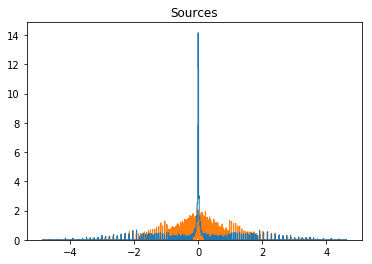

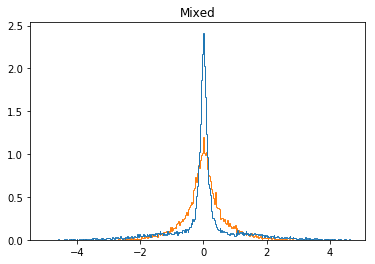

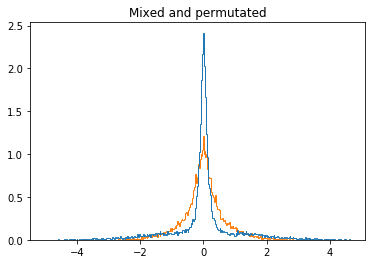

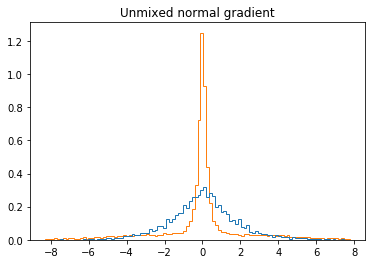

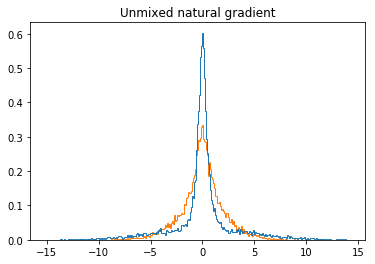

In [13]:
plt.figure()
h = plt.hist(s.T, bins='auto',normed=True,histtype = 'step')
plt.title('Sources')
plt.figure()
h = plt.hist(x.T, bins='auto',normed=True,histtype = 'step')
plt.title('Mixed')
plt.figure()
h = plt.hist(x_per.T, bins='auto',normed=True,histtype = 'step')
plt.title('Mixed and permutated')
plt.figure()
h = plt.hist(unmixedNormal.T, bins='auto',normed=True,histtype = 'step')
plt.title('Unmixed normal gradient')
plt.figure()
h = plt.hist(unmixedNatural.T, bins='auto',normed=True,histtype = 'step')
plt.title('Unmixed natural gradient')
plt.show()